# Main housing construction period

In [1]:
from pynsee.download import get_file_list, get_column_metadata, download_file
from pynsee.geodata import get_geodata, get_geodata_list

import math
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
meta = get_file_list()
metacol = get_column_metadata("RP_LOGEMENT_2016")

Existing environment variable sirene_key used, instead of locally saved credentials
https://minio.lab.sspcloud.fr/pierrelamarche/melodi/liste_donnees.json
https://raw.githubusercontent.com/InseeFrLab/DoReMIFaSol/master/data-raw/liste_donnees.json
pynsee.download's metadata rely on volunteering contributors and their manual updates. get_file_list does not provide data from official Insee's metadata API
Consequently, please report any issue
Column-specific metadata has been found for this file


In [4]:
meta_achl = metacol[metacol["column"] == "ACHL"].reset_index(drop=True)
meta_achl.loc[~meta_achl["value"].isin(["A11", "A12", "B11", "B12", "C100"]), "value"] = ">2005"
meta_achl.loc[meta_achl["value"] == ">2005", "value_label_fr"] = "Après 2005"
meta_achl = meta_achl[["value", "value_label_fr"]].drop_duplicates()
meta_achl.columns = ["ACHL", "ACHL_label_fr"]
meta_achl

,ACHL,ACHL_label_fr
0,A11,Avant 1919
1,A12,De 1919 à 1945
2,B11,De 1946 à 1970
3,B12,De 1971 à 1990
4,C100,De 1991 à 2005
5,>2005,Après 2005


In [5]:
df = download_file("RP_LOGEMENT_2017", variables = ["COMMUNE", "IRIS", "ACHL", "IPONDL"], silent=True)
DF = df[["COMMUNE", "IRIS", "ACHL", "IPONDL"]].reset_index(drop=True)
DF["IPONDL"] = pd.to_numeric(DF["IPONDL"])
DF = DF.groupby(["COMMUNE", "IRIS", "ACHL"], as_index=False).IPONDL.agg("sum")

In [6]:
pondTot = DF.groupby(["COMMUNE", "IRIS"], as_index=False)['IPONDL'].agg('sum')
pondTot = pondTot.rename(columns={'IPONDL': 'pondTot'})
DF = DF.merge(pondTot, on = ["COMMUNE", "IRIS"], how='left')

In [7]:
DF["pct"] = DF["IPONDL"] / DF["pondTot"] * 100
DF.loc[~DF["ACHL"].isin(["A11", "A12", "B11", "B12", "C100"]), "ACHL"] = ">2005"
data = DF.groupby(["COMMUNE", "IRIS", "ACHL"], as_index=False).pct.agg("sum")
data = data.merge(meta_achl, on = "ACHL", how="left")

ix = data[data["IRIS"].str.fullmatch("Z+")].index
data.loc[ix, "IRIS"] = data.loc[ix, "COMMUNE"] + "0000"

In [8]:
data.head(10)

,COMMUNE,IRIS,ACHL,pct,ACHL_label_fr
0,01001,010010000,>2005,7.141565,Après 2005
1,01001,010010000,A11,28.765250,Avant 1919
2,01001,010010000,A12,3.160147,De 1919 à 1945
3,01001,010010000,B11,3.445027,De 1946 à 1970
4,01001,010010000,B12,29.377355,De 1971 à 1990
5,01001,010010000,C100,28.110656,De 1991 à 2005
6,01002,010020000,>2005,9.469609,Après 2005
7,01002,010020000,A11,62.087134,Avant 1919
8,01002,010020000,A12,10.058386,De 1919 à 1945
9,01002,010020000,B11,4.744642,De 1946 à 1970


In [9]:
shp = get_geodata('STATISTICALUNITS.IRIS:contours_iris', crs=3857).rename(columns={"code_iris": "IRIS"})

Previously saved data has been used:
C:\Users\utilisateur\AppData\Local\pynsee\pynsee\Cache\pynsee\c3913eda113a24f853840db21260211e.parquet
Creation date: 2025-03-06, today
Set update=True to get the most up-to-date data


In [10]:
data['pct_max'] = data.groupby(['COMMUNE', "IRIS"])['pct'].transform("max")
dataMax = data[data["pct"] == data["pct_max"]].reset_index(drop=True)

dataMax["insee_dep"] = dataMax.COMMUNE.str[:2]
ix = dataMax[dataMax.COMMUNE.str.startswith("97")].index
dataMax.loc[ix, "insee_dep"] = dataMax.loc[ix, "COMMUNE"].str[:3]

dataFinal = shp[["IRIS", "geometry", "nom_commune"]].merge(dataMax, on="IRIS", how = "right")

In [11]:
# iris limit missing for the following iris 
dataFinal.loc[dataFinal["geometry"].isnull(),['insee_dep', "COMMUNE", "nom_commune","IRIS", "geometry", "pct"]]

,insee_dep,COMMUNE,nom_commune,IRIS,geometry,pct
46,01,01039,NaN,010390000,None,22.760680
525,02,02077,NaN,020770000,None,24.725275
1168,02,02695,NaN,026950000,None,43.589744
3240,08,08294,NaN,082940000,None,55.816870
3719,09,09255,NaN,092550000,None,40.280210
...,...,...,...,...,...,...
48920,973,97311,NaN,973110107,None,50.234350
48925,973,97353,NaN,973530000,None,49.746619
48927,973,97357,NaN,973570000,None,45.966446
48929,973,97360,NaN,973600000,None,51.353086


In [12]:
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune', crs=3857).rename(columns={"insee_com": "COMMUNE"})

Previously saved data has been used:
C:\Users\utilisateur\AppData\Local\pynsee\pynsee\Cache\pynsee\ffa594579baf3f7e2e58a7b18b011d02.parquet
Creation date: 2025-03-06, today
Set update=True to get the most up-to-date data


In [13]:
# fill geometries using full commune
dataFinal["geometry"] = dataFinal["geometry"].combine_first(dataFinal[["COMMUNE"]].merge(com, on="COMMUNE", how="left")["geometry"])

In [14]:
dataFinal = dataFinal[~dataFinal.geometry.isnull()]
gdf_transformed = (
    dataFinal
    .transform_overseas()
    .zoom(["75","92", "93", "91", "77", "78", "95", "94"], factor=1.5, startAngle = math.pi * (1 - 3 * 1/9))
)

Previously saved data has been used:
C:\Users\utilisateur\AppData\Local\pynsee\pynsee\Cache\pynsee\f2bbdea5546ef02791b1286f1b6b1a51.parquet
Creation date: 2025-03-06, today
Set update=True to get the most up-to-date data
976 is missing from insee_dep column !


In [15]:
gdf_transformed['ACHL_label_en'] = gdf_transformed['ACHL_label_fr'].astype(str)
gdf_transformed = gdf_transformed.replace({'ACHL_label_en': {"Après": "After", "Avant" : "Before", "De" : "From", "à" : "to"}}, regex=True)
list_ranges_ACHL_label_en = ['Before 1919', 'From 1919 to 1945', 'From 1946 to 1970', 'From 1971 to 1990','From 1991 to 2005', 'After 2005']
gdf_transformed['ACHL_label_en'] = gdf_transformed['ACHL_label_en'].astype(CategoricalDtype(categories=list_ranges_ACHL_label_en, ordered=True))

In [16]:
gdf_transformed.head(3)

,IRIS,geometry,nom_commune,COMMUNE,ACHL,pct,ACHL_label_fr,pct_max,insee_dep,ACHL_label_en
0,010010000,"MULTIPOLYGON (((551967.855 5804945.492, 551935...",L'Abergement-Clémenciat,01001,B12,29.377355,De 1971 à 1990,29.377355,01,From 1971 to 1990
1,010020000,"MULTIPOLYGON (((604487.363 5777589.278, 604442...",L'Abergement-de-Varey,01002,A11,62.087134,Avant 1919,62.087134,01,Before 1919
2,010040101,"MULTIPOLYGON (((593073.88 5773654.625, 593083....",Ambérieu-en-Bugey,01004,B12,40.024794,De 1971 à 1990,40.024794,01,From 1971 to 1990


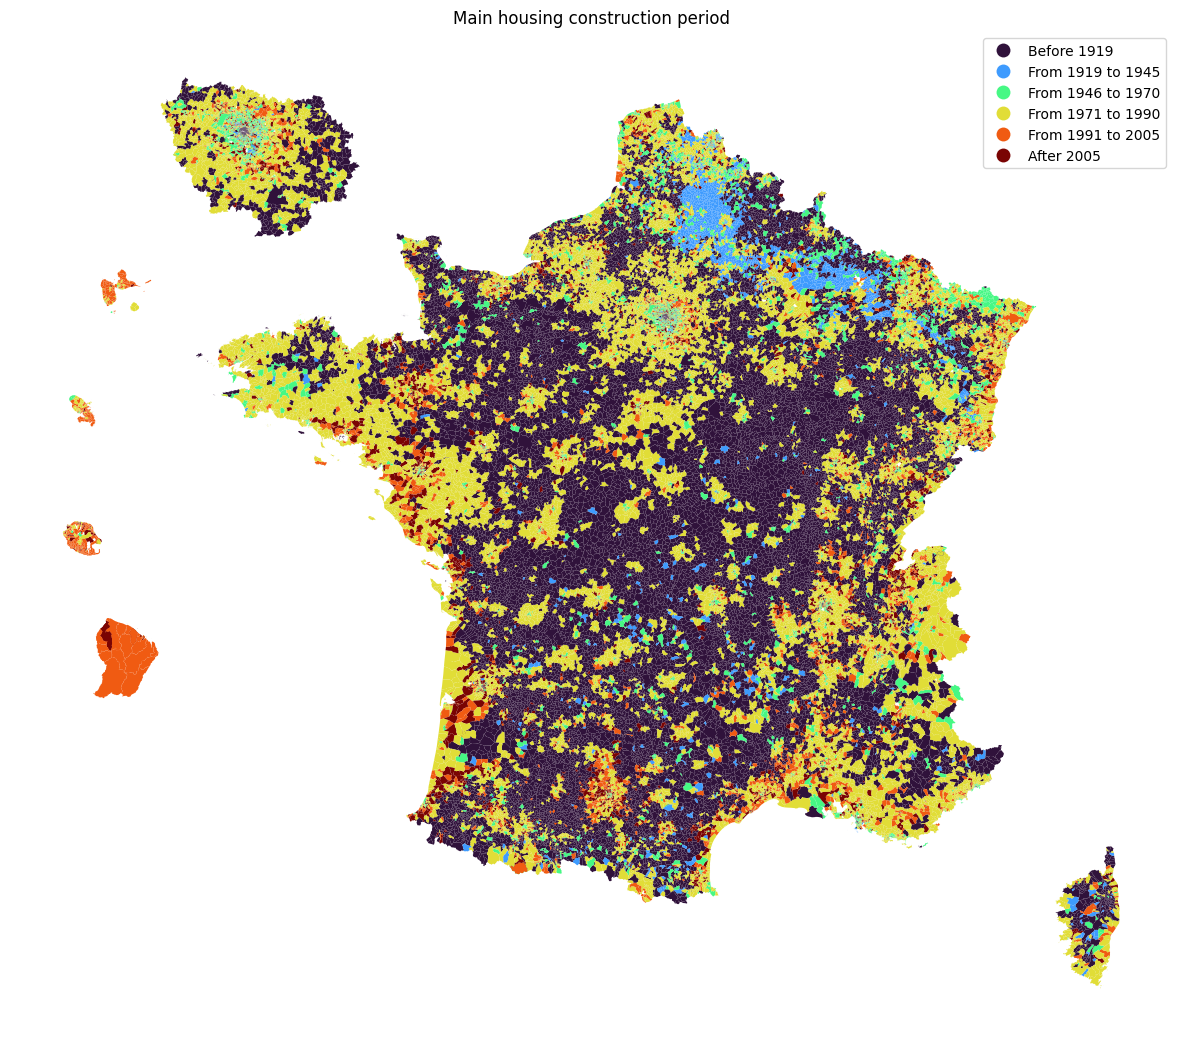

In [17]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
gdf_transformed.plot(column='ACHL_label_en', cmap=cm.turbo,
               legend=True, ax=ax)
ax.set_axis_off()
ax.set(title='Main housing construction period')
plt.show()